In [1]:
class Config:
    name = "EDAs/Noise/EDA002"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"

    # Kaggle Env
    kaggle_dataset_path = None

    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [2]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

## Environment Settings

In [3]:
INPUT = os.path.join(Config.dir_path, 'input')
OUTPUT = os.path.join(Config.dir_path, 'output')
SUBMISSION = os.path.join(Config.dir_path, 'submissions')
OUTPUT_EXP = os.path.join(OUTPUT, Config.name)
EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

# make dirs
for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
    os.makedirs(d, exist_ok=True)

## Load data

In [7]:
train = pd.read_parquet(os.path.join(INPUT, 'train.parquet'))
test = pd.read_parquet(os.path.join(INPUT, 'test.parquet'))
# https://www.kaggle.com/code/raddar/amex-data-int-types-train
train_original = pd.read_parquet(os.path.join(INPUT, 'train_data.parquet'))
test_original = pd.read_parquet(os.path.join(INPUT, 'test_data.parquet'))
target = pd.read_csv(os.path.join(INPUT, 'train_labels.csv'), dtype={'customer_ID': 'str', 'target': 'int8'})

# with open(os.path.join(INPUT, 'data_types.json'), "r") as rf:
#     dtypes = json.load(rf)
# train = train.astype(dtypes)
# test = test.astype(dtypes)

In [10]:
train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 7.8+ GB


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(9), int8(86), object(2)
memory usage: 2.5+ GB


In [12]:
test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363762 entries, 0 to 11363761
Columns: 190 entries, customer_ID to D_145
dtypes: float64(185), int64(1), object(4)
memory usage: 16.1+ GB


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363762 entries, 0 to 11363761
Columns: 190 entries, customer_ID to D_145
dtypes: float32(93), int16(10), int8(85), object(2)
memory usage: 5.2+ GB


## Evaluation Metric

In [14]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(pd.DataFrame({'target': y_true}), pd.Series(y_pred, name='prediction')),
            True)

## Explatory Data Analysis

<AxesSubplot:xlabel='B_2'>

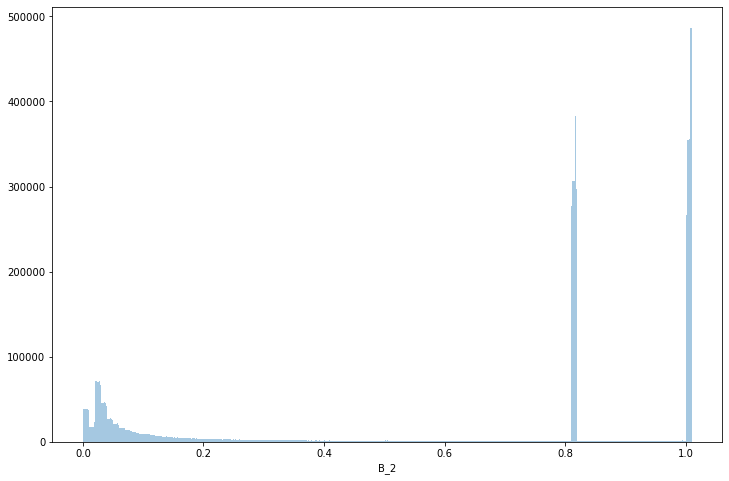

In [24]:
plt.figure(figsize=(12, 8))
sns.distplot(train['B_2'], bins=500, kde=False)

<AxesSubplot:xlabel='B_2'>

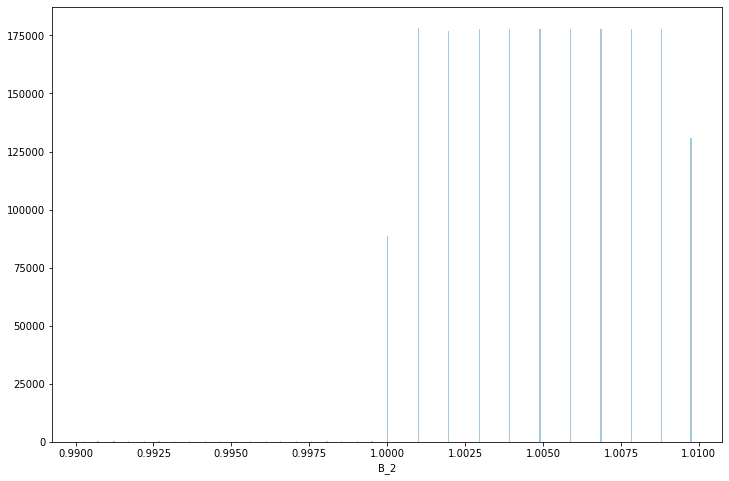

In [25]:
plt.figure(figsize=(12, 8))
sns.distplot(train.loc[train['B_2']>0.99,'B_2'],bins=500,kde=False)

<AxesSubplot:xlabel='B_2'>

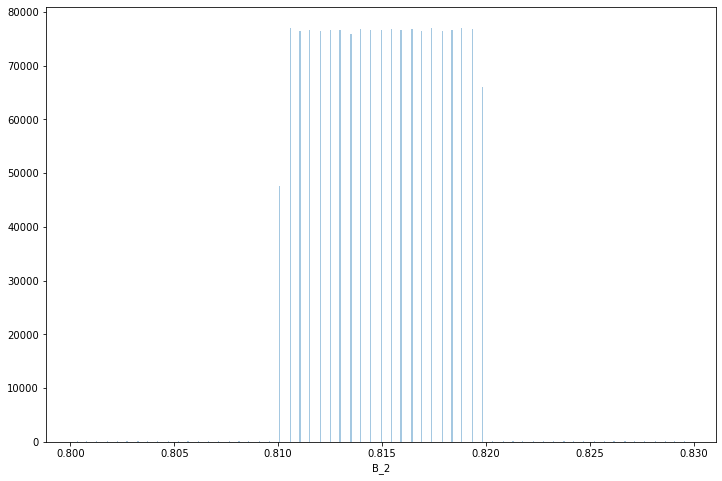

In [20]:
plt.figure(figsize=(12, 8))
sns.distplot(train.loc[(train['B_2']>0.8) & (train['B_2']<0.83),'B_2'],bins=500,kde=False)